In [1]:
# Load required package
import math 
import tejapi
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
plt.style.use('ggplot')

# log in TEJ API
api_key = 'YOUR_KEY'
tejapi.ApiConfig.api_key = api_key
tejapi.ApiConfig.ignoretz = True

# set time zone
gte, lte = '2021-03-16', '2023-04-20'

# Get stock price
stocks = tejapi.get('TWN/APRCD',
                   paginate = True,
                   coid = 'Y9999',
                   mdate = {'gte':gte, 'lte':lte},
                   opts = {
                       'columns':[ 'mdate','close_d']
                   }
                  )

# Get options price
puts = tejapi.get(
    'TWN/AOPTION',
    paginate = True,
    coid = 'TXO202304P15500',
    mdate = {'gte':gte, 'lte':lte},
    opts = {
        'columns':['mdate', 'coid','settle', 'kk', 'theoremp', 'acls', 'ex_price', 'td1y', 'avolt', 'rtime']
    }
)
calls = tejapi.get(
    'TWN/AOPTION',
    paginate = True,
    coid = 'TXO202304C15500',
    mdate = {'gte':gte, 'lte':lte},
    opts = {
        'columns':['mdate', 'coid','settle', 'kk', 'theoremp', 'acls', 'ex_price', 'td1y', 'avolt', 'rtime']
    }
)

# Calculate stock return and moving volatility
stocks['daily return'] = np.log(stocks['close_d']) - np.log(stocks['close_d'].shift(1))
stocks['moving volatility'] = stocks['daily return'].rolling(252).std()
stocks = stocks.set_index('mdate')
puts = puts.set_index('mdate')
calls = calls.set_index('mdate')

In [2]:
class crr_model:
    
    # init fuction
    def __init__(self, s, x, r, t, sigma, N, sigma_daily = True):
        
        t /= 252 
        dt = t/N 
        if sigma_daily:
            sigma *= np.sqrt(252)
        u = np.exp(sigma * math.sqrt(dt))
        d = 1/u
        p = (np.exp(r*dt)-d) / (u-d)
        
        self.s = s
        self.x = x
        self.r = r
        self.t = t
        self.N = N 
        self.dt = dt
        self.u = u
        self.d = d
        self.p = p
        self.sigma = sigma
    
    # european call price
    def eu_call_price(self):
        
        lattice = np.zeros((self.N+1, self.N+1))
        for j in range(self.N+1):
            lattice[self.N, j] = max(0, self.s*(self.u**j)*(self.d**(self.N-j)) - self.x)
        for i in range(self.N-1, -1, -1):
            for j in range(i+1):
                lattice[i, j] = np.exp(-self.r*self.dt)*(self.p*lattice[i+1,j+1] + (1-self.p) * lattice[i+1, j])
    
        return lattice[0,0], lattice
    
    # european put price
    def eu_put_price(self):
        
        lattice = np.zeros((self.N+1, self.N+1))
        for j in range(self.N+1):
            lattice[self.N, j] = max(0, self.x - self.s*(self.u**j)*(self.d**(self.N-j)))
        for i in range(self.N-1, -1, -1):
            for j in range(i+1):
                lattice[i, j] = np.exp(-self.r*self.dt)*(self.p*lattice[i+1,j+1] + (1-self.p) * lattice[i+1, j])
    
        return lattice[0,0], lattice
    
    # american call price
    def am_call_price(self):
        
        lattice = np.zeros((self.N+1, self.N+1))
        for j in range(self.N+1):
            lattice[self.N, j] = max(0, self.s*(self.u**j)*(self.d**(self.N-j)) - self.x)
        for i in range(self.N-1, -1, -1):
            for j in range(i+1):
                lattice[i, j] = max(np.exp(-self.r*self.dt)*(self.p*lattice[i+1,j+1] + (1-self.p) * lattice[i+1, j]),
                                   self.s*(self.u**j)*(self.d**(i-j)) - self.x )
    
        return lattice[0,0], lattice        
    
    # american put price
    def am_put_price(self):

        lattice = np.zeros((self.N+1, self.N+1))
        for j in range(self.N+1):
            lattice[self.N, j] = max(0, self.x - self.s*(self.u**j)*(self.d**(self.N-j)))
        for i in range(self.N-1, -1, -1):
            for j in range(i+1):
                lattice[i, j] = max(
                    np.exp(-self.r*self.dt)*(self.p*lattice[i+1,j+1] + (1-self.p) * lattice[i+1, j]), 
                    self.x - self.s*(self.u**j)*(self.d**(i-j))
                                   )
    
        return lattice[0,0], lattice                                    

In [3]:
s = 100
x = 95
r = 0
t = 252
sigma = 0.3
N = 4

crr = crr_model(s, x, r, t, sigma, N, sigma_daily = False)
call, call_lat = crr.eu_call_price()
call_lat

array([[14.35480056,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 5.68258642, 24.43047591,  0.        ,  0.        ,  0.        ],
       [ 1.06985574, 11.04181488, 39.98588076,  0.        ,  0.        ],
       [ 0.        ,  2.31285077, 21.18342427, 61.83121855,  0.        ],
       [ 0.        ,  0.        ,  5.        , 39.98588076, 87.21188004]])

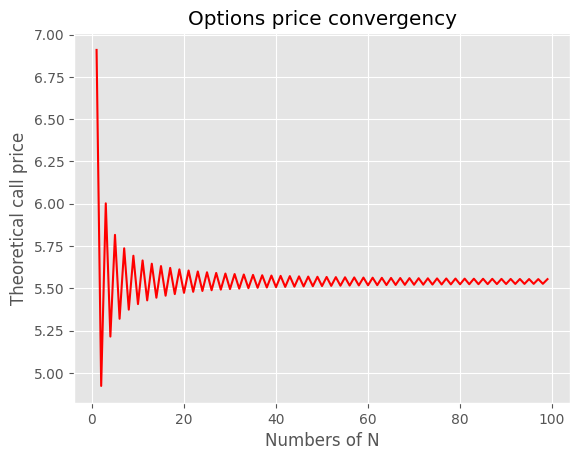

In [4]:
# plot the stablization pattern of crr model

calls_ = []
for n in range(1, 100):
    
    s = 100
    x = 100
    r = 0.011
    t = 52
    sigma = 0.3
    
    crr = crr_model(s, x, r, t, sigma, n, sigma_daily = False)
    call, call_lat = crr.eu_call_price()
    calls_.append(call)
    
plt.plot(range(1, 100), calls_, color = 'red')
plt.xlabel('Numbers of N')
plt.ylabel('Theoretical call price')
plt.title('Options price convergency')
# plt.savefig('Options price convergency')
plt.show()

In [15]:
s = stocks.loc['2023-01-31']['close_d'] # get the stock price at the first dat of options trading
x = 15500 # strike price
r = 0.011 # use 5-year Taiwan government bond ytm
t = 51 # time to maturity
sigma = stocks.loc['2023-01-31']['moving volatility'] # get the return volatility at the first day od options trading
N = 100 # divided time 2 maturity into 10 parts

crr = crr_model(s, x, r, t, sigma, N, sigma_daily = True)
call, call_lat = crr.eu_call_price()
put, put_lat = crr.eu_put_price()
call_a, call_lat_a = crr.am_call_price()
put_a, put_lat_a = crr.am_put_price()

In [18]:
print('CRR theoretical price: ', round(put,4))
print('TEJ Black Scholes price: ', round(puts.loc['2023-01-31']['theoremp'],4))
print('Real price: ', puts.loc['2023-01-31']['settle'])

CRR theoretical price:  665.6911
TEJ Black Scholes price:  708.365
Real price:  650.0
